In [1]:

import json
import spacy
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List
from string import punctuation
from scipy.stats import wilcoxon


In [2]:
# !python -m spacy download en_core_web_sm
spacy.load('en_core_web_sm')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 12.8/12.8 MB 89.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Text Processing

## TF-IDF

In [3]:

def gen_tfidf(texts, min_df=1.0, max_df=1.0, ngram_range=(1, 1)):
    """
    texts: a list of strings
    """

    # using default tokenizer in TfidfVectorizer
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)

    features = tfidf.fit_transform(texts)

    df = pd.DataFrame(
                    features.todense(),
                    columns=tfidf.get_feature_names_out()
                    )
    return df


### examples

In [4]:

bi =  {"min_df": 2, "max_df": 0.5, "ngram_range": (1,2)}
uni = {"min_df": 2, "max_df": 3}
texts = [
    (["good movie", "not a good movie", "did not like", "i like it", "good one"], 
        (("good movie", bi), ("good", uni), ("movie", uni))),
    (['a great film', 'great cast', 'a pleasure to watch', 'not good', 'hard to watch', 'boring film'],
        (("film", uni),))
]

for text, params in texts:
    ng = ""
    for term, args in params:
        df = gen_tfidf(text, **args)
        ngrams = ""
        n = len(term.split(" "))
        res = f"{n}-gram sum('{term}'): {df[term].sum():.4}\n"
        ngrams += res
    
        ng += f"{'-'*80}\n{df}\n{ngrams}\n"    
    print(ng)


--------------------------------------------------------------------------------
   good movie      like     movie       not
0    0.707107  0.000000  0.707107  0.000000
1    0.577350  0.000000  0.577350  0.577350
2    0.000000  0.707107  0.000000  0.707107
3    0.000000  1.000000  0.000000  0.000000
4    0.000000  0.000000  0.000000  0.000000
2-gram sum('good movie'): 1.284

--------------------------------------------------------------------------------
       good      like     movie       not
0  0.638711  0.000000  0.769447  0.000000
1  0.506204  0.000000  0.609818  0.609818
2  0.000000  0.707107  0.000000  0.707107
3  0.000000  1.000000  0.000000  0.000000
4  1.000000  0.000000  0.000000  0.000000
1-gram sum('good'): 2.145

--------------------------------------------------------------------------------
       good      like     movie       not
0  0.638711  0.000000  0.769447  0.000000
1  0.506204  0.000000  0.609818  0.609818
2  0.000000  0.707107  0.000000  0.707107
3  0.000000  

## Tokenizer

In [42]:

class Tokenizer():
    def __init__(self, mode="basic"):
        self.mode = mode
        self.vocab = {}
        self.tokenized = None

    def tokenize_basic(self, docs, reset_vocabulary=False):
        """Tokenizes a sentence to get tokens and vocab freq dict
        * accepts a sentence (i.e., `text` parameter) as an input
        * splits the sentence into a list of tokens by **space**
        * removes the **leading/trailing punctuations or spaces** of each token, if any
        * only keeps tokens with 2 or more characters, i.e. `len(token)>1`
        * converts all tokens into lower case
        * find the count of each unique token and save the counts as dictionary, i.e., `{world: 1, a: 1, ...}`
        :param str text: sentence (corpus)
        """

        punct = punctuation + '\u201c\u201d\u2018\u2019'
        # Remove any leading or trailing punctuation and spaces/tabs/new lines from each
        # If a word is longer than 2 letters, covert to lower case and keep
        tokens = [
            [t.lower().strip(punct) for t in doc.split() if len(t) > 1]
            for doc in docs
        ]
        # Store word count in vocab dict
        vocab = {}
        for doc in tokens:
            for t in doc:
                if t not in vocab:
                    vocab[t] = 1.0
                else:
                    vocab[t] += 1.0
            if reset_vocabulary:
                self.vocab = vocab
            else:
                self.vocab.update(vocab)
        
        self.vocab = dict(sorted(self.vocab.items(), key=lambda v: v[1], reverse=True))
        
        return tokens

    def tokenize_doc(self, doc, nlp, lemmatized=True, remove_stopword=True, remove_punct=True):
        clean_tokens = []
        # load current doc into spacy nlp model and split sentences by newline chars
        sentences = doc.split("\\n")
        for sentence in sentences:
            doc = nlp(sentence)

            # clean either lemmatized unigrams or unmodified doc tokens
            if lemmatized:
                clean_tokens += [token.lemma_.lower() for token in doc            # using spacy nlp params, skip token if:
                                if (not remove_stopword or not token.is_stop)     # it is a stopword and remove_stopwords = True
                                and (not remove_punct or not token.is_punct)      # it is punctuation and remove_punct = True
                                and not token.lemma_.isspace()]                   # it is whitespace
            else:
                clean_tokens += [token.text.lower() for token in doc
                                if (not remove_stopword or not token.is_stop)
                                and (not remove_punct or not token.is_punct)
                                and not token.text.isspace()]

        return clean_tokens

    def tokenize_spacy(self, docs, lemmatized=True, remove_stopword=True, remove_punct=True):
        """Tokenize documents using methods from the SpaCy library.
        (ref: https://spacy.io/api/token#attributes)
        
        Splits each input document into unigrams and also clean up tokens as follows:
        - if `lemmatized` is turned on, lemmatize all unigrams.
        - if `remove_stopword` is set to True, remove all stop words.
        - if `remove_punct` is set to True, remove all punctuation tokens.
        - remove all empty tokens and lowercase all the tokens.
        
        Parameters:
            docs (List[str]): a list of documents.
            lemmatized (bool): optional parameter to indicate if tokens are lemmatized. Defaults to True.
            remove_stopword(bool): optional parameter to remove stop words. Defaults to True.
            remove_punct(bool): optional parameter to remove punctuation. Defaults to True.
  
        Returns:
            out (list): tokens obtained for each document after all the processing.
        """

        # load in spacy NLP model and disable unused pipelines to reduce processing time/memory space
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        nlp.add_pipe("sentencizer")
        # tokenize each doc in the corpus using specified params for lemmatization and removal conditions
        tokens = [self.tokenize_doc(doc, nlp, lemmatized, remove_stopword, remove_punct) for doc in docs]
        return tokens

    def tokenize(self, docs, **kwargs):
        
        tokens = []
        if self.mode == "basic":
            tokens = self.tokenize_basic(docs, **kwargs)
        elif self.mode == "spacy":
            tokens = self.tokenize_spacy(docs, **kwargs)
        self.tokenized = tokens
        return tokens


### examples

In [6]:

## example 1 ##
# basic tokenizer
docs = pd.read_csv("../data/sents.csv")["text"]

tokenizer = Tokenizer()
tokenizer.tokenize(docs)

print(f"{docs[:5]}\n\n{json.dumps(tokenizer.vocab, indent=4)}")

## example 2 ##
data = pd.read_csv("../data/qa.csv")

# build parameter dicts
params = [
        (True, False, True),
        (True, True, True),
        (False, False, True),
        (False, False, False)     
    ]
params = [dict(zip(["lemmatized", "remove_stopword", "remove_punct"], par)) for par in params]

# get example document
docs = data["question"].iloc[0:1]
print(f"Original document:\n{docs[0]}\n")

# tokenize
tokenizer = Tokenizer("spacy")
print("Tokenized:\n")
for param_tuple in params:
    tokenizer.tokenize(docs, **param_tuple)
    print(f"{param_tuple}:\n{tokenizer.tokenized}\n")


0            The Power of Natural Language Processing.
1    Until recently, the conventional wisdom was th...
2    But in the past two years language-based AI ha...
3    It has been used to write an article for The G...
4    AI even excels at cognitive tasks like program...
Name: text, dtype: object

{
    "the": 68.0,
    "to": 65.0,
    "and": 52.0,
    "of": 50.0,
    "for": 37.0,
    "ai": 25.0,
    "in": 24.0,
    "is": 23.0,
    "are": 22.0,
    "tasks": 20.0,
    "like": 20.0,
    "be": 20.0,
    "your": 20.0,
    "data": 19.0,
    "but": 18.0,
    "that": 17.0,
    "can": 17.0,
    "it": 15.0,
    "this": 14.0,
    "you": 14.0,
    "language": 13.0,
    "on": 13.0,
    "tools": 13.0,
    "models": 12.0,
    "or": 11.0,
    "an": 10.0,
    "from": 10.0,
    "text": 10.0,
    "research": 10.0,
    "not": 10.0,
    "how": 9.0,
    "will": 9.0,
    "language-based": 8.0,
    "has": 8.0,
    "even": 8.0,
    "may": 8.0,
    "more": 8.0,
    "model": 8.0,
    "was": 7.0,
    "better"

## Performance Evaluation (Precision and Recall)

In [64]:

def evaluate_performance(prob, truth, th):
    """Compares the prediction with the ground truth labels to calculate
    the confusion matrix as [[TN, FN],[FP,TP]], where:
    * True Positives (TP): the number of correct positive predictions
    * False Positives (FP): the number of postive predictives which actually are negatives
    * True Negatives (TN): the number of correct negative predictions
    * False Negatives (FN): the number of negative predictives which actually are positives

    :return precision: TP/(TP+FP)
    :return recall: TP/(TP+FN)
    """
    
    conf = [[0, 0], [0, 0]]
    classifiers = list(zip(prob, truth))

    for p,t in classifiers:
        guess = 0
        if p > th:
            guess = 1
        if guess == t:
                if guess == 0:
                    conf[0][0] += 1
                else:
                    conf[1][1] += 1
        else:
            if guess == 0:
                conf[0][1] += 1
            else:
                conf[1][0] += 1

    [[TN,FN],[FP,TP]] = conf
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)

    performance = {
        "R0": prec,
        "R1": rec
    }
    return performance

def bigram_precision_recall(gen_tokens, ref_tokens):
    result = pd.DataFrame(columns = ['overlapping','precision','recall'])

    gen_bigrams = [list(nltk.bigrams(tokens)) for tokens in gen_tokens]
    ref_bigrams = [list(nltk.bigrams(tokens)) for tokens in ref_tokens]

    bigrams = list(zip(gen_bigrams, ref_bigrams))

    overlapping = []
    precision = []
    recall = []
    for gen, ref in bigrams:
        overlap = [tup1 for tup1 in gen for tup2 in ref if tup1 == tup2]
        overlapping.append(list(set(overlap)))

        prec = 0
        if gen:
            prec = len(overlap)/len(gen)
        precision.append(prec)

        rec = 0
        if ref:
            rec = len(overlap)/len(ref)
        recall.append(rec)

    result['overlapping'] = overlapping
    result['precision'] = precision
    result['recall'] = recall

    return result


### examples

Precision/Recall

One Value Only:
{
    "R0": 0.2608695652173913,
    "R1": 1.0
}

All Values:
          prec       rec
0.05  0.260870  1.000000
0.10  0.342857  1.000000
0.15  0.480000  1.000000
0.20  0.705882  1.000000
0.25  0.857143  1.000000
0.30  0.916667  0.916667
0.35  0.916667  0.916667
0.40  0.916667  0.916667
0.45  0.916667  0.916667
0.50  0.909091  0.833333
0.55  0.909091  0.833333
0.60  0.909091  0.833333
0.65  0.900000  0.750000
0.70  0.888889  0.666667
0.75  1.000000  0.500000
0.80  1.000000  0.500000
0.85  1.000000  0.416667
0.90  1.000000  0.250000
0.95  1.000000  0.083333



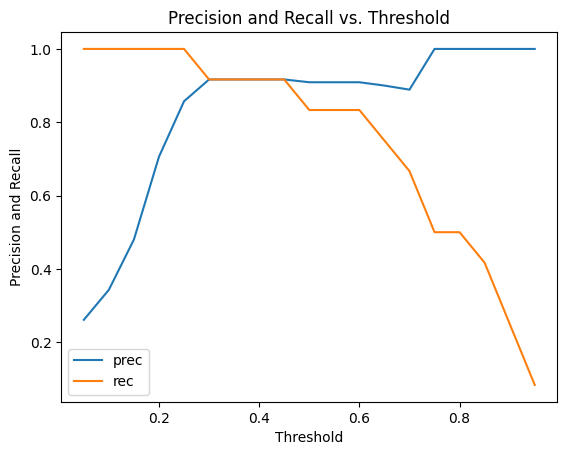

In [8]:

prob =np.array([0.28997326, 0.10166073, 0.10759583, 0.0694934 , 0.6767239 ,
       0.01446897, 0.15268748, 0.15570522, 0.12159665, 0.22593857,
       0.98162019, 0.47418329, 0.09376987, 0.80440782, 0.88361167,
       0.21579844, 0.72343069, 0.06605903, 0.15447797, 0.10967575,
       0.93020135, 0.06570391, 0.05283854, 0.09668829, 0.05974545,
       0.04874688, 0.07562255, 0.11103822, 0.71674525, 0.08507381,
       0.630128  , 0.16447478, 0.16914903, 0.1715767 , 0.08040751,
       0.7001173 , 0.04428363, 0.19469664, 0.12247959, 0.14000294,
       0.02411263, 0.26276603, 0.11377073, 0.07055441, 0.2021157 ,
       0.11636899, 0.90348488, 0.10191679, 0.88744523, 0.18938904])

truth = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
                1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
                0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 1, 0, 1, 0])

# Test with threhold grid varying from 0.05 to 0.95 with an increase of 0.05
th_list = np.arange(0.05, 1.00, 0.05)

vals = [tuple(evaluate_performance(prob, truth, th).values()) for th in th_list]
prec, rec = zip(*vals)
vals_df = pd.DataFrame(vals, columns = ['prec', 'rec'], index = th_list)
result = evaluate_performance(prob, truth, 0.05)

print(f"Precision/Recall\n\nOne Value Only:\n{json.dumps(result, indent=4)}\n")
print(f"All Values:\n{vals_df}\n")

plt.plot(th_list, vals_df, label = ['prec','rec'])
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')
plt.legend()
plt.show()


## Determine Sentiment

In [ ]:

def compute_sentiment(target, pos, neg):
    sentiment = 0
    p = sum(1 for word in target if word in pos)
    n = sum(1 for word in target if word in neg)
    if p + n != 0:
        sentiment = (p - n) / (p + n)
    return sentiment

def sentiment(gen_tokens, ref_tokens, pos, neg):
    print(gen_tokens)
    tokens = lambda token_list: [compute_sentiment(sublist, pos, neg) for sublist in token_list]

    result = pd.DataFrame({'gen_sentiment': tokens(gen_tokens), 
                           'ref_sentiment': tokens(ref_tokens)})

    avg = (result['gen_sentiment'] - result['ref_sentiment']).mean()
    res = wilcoxon(result['gen_sentiment'] - result['ref_sentiment'], alternative='greater')

    print(f"Average Sentiment: {avg}\n")
    print(f"Stat: {res.statistic}\nP-Value: {res.pvalue}\n")
    return result


### examples

In [50]:

pos_words = pd.read_csv("../data/positive-words.txt", header=None)
pos = pos_words[0].values

neg_words = pd.read_csv("../data/negative-words.txt", header=None)
neg = neg_words[0].values

gen = data["chatgpt_answer"]
ref = data["human_answer"]


In [65]:
tokenizer = Tokenizer("spacy")
combos = [(True, False, False),
            (True, True, False),
            (True, False, True),
            (True, True, True),
            (False, False, True),
            (False, False, False)]

for lemmatized, stopword, punct in combos:
    print(f"lemmatized={lemmatized}, remove_stopword={stopword}, remove_punct={punct}")
    
    gen_tokens = tokenizer.tokenize(gen, lemmatized=lemmatized, remove_stopword=stopword, remove_punct=punct)
    ref_tokens = tokenizer.tokenize(ref, lemmatized=lemmatized, remove_stopword=stopword, remove_punct=punct)
    text_sentiment = sentiment(gen_tokens, ref_tokens, pos, neg)
    result = bigram_precision_recall(gen_tokens, ref_tokens)
    
    print(result[["precision", "recall"]].mean(axis = 0), text_sentiment.describe(), "\n")
    


lemmatized=True, remove_stopword=False, remove_punct=False
[['if', 'a', 'parking', 'ticket', 'be', 'lose', 'or', 'destroy', 'before', 'the', 'owner', 'be', 'aware', 'of', 'it', 'and', 'it', 'go', 'unpaid', ',', 'the', 'owner', 'may', 'be', 'subject', 'to', 'additional', 'fine', 'or', 'penalty', '.', 'it', 'be', 'important', 'for', 'the', 'owner', 'of', 'a', 'vehicle', 'to', 'check', 'for', 'any', 'parking', 'ticket', 'regularly', 'and', 'to', 'pay', 'any', 'ticket', 'that', 'have', 'be', 'issue', 'in', 'a', 'timely', 'manner', '.', 'if', 'a', 'ticket', 'be', 'lose', 'or', 'destroy', ',', 'the', 'owner', 'should', 'contact', 'the', 'issue', 'agency', 'as', 'soon', 'as', 'possible', 'to', 'explain', 'the', 'situation', 'and', 'see', 'if', 'it', 'be', 'possible', 'to', 'resolve', 'the', 'issue', '.', 'it', 'be', 'always', 'well', 'to', 'try', 'to', 'take', 'care', 'of', 'a', 'parking', 'ticket', 'as', 'soon', 'as', 'possible', 'to', 'avoid', 'any', 'additional', 'fine', 'or', 'consequence

## Document term matrix (DTM)

In [66]:

def get_dtm(sents):
    """
    - accepts a list of sentences, i.e., `sents`, as an input
    - call `tokenize` function you defined in Q1 to get the count dictionary for each sentence, and combine them into a list
    - call `generate_vocab` function in Q2 to generate the large vocabulary for all sentences, and get all the words, i.e., keys
    - creates a numpy array, say `dtm` with a shape (# of docs x # of unique words), and set the initial values to 0.
    - fills cell `dtm[i,j]` with the count of the `j`th word in the `i`th sentence. HINT: you can loop through the list of 
    vocabulary from step 2, and check each word's index in the large vocabulary from step 3, so that you can put the 
    corresponding value into the correct cell.
    - returns `dtm` and `unique_words`
    """

    tokenizer = Tokenizer("spacy")
    tokenizer.tokenize(sents, lemmatized=True, remove_stopword=True, remove_punct=True)
    
    all_docs = tokenizer.tokenized
    all_words = tokenizer.vocab

    m,n = len(all_docs), len(all_words)
    dtm = np.zeros((m,n))

    for doc in range(m):
        for i, word in enumerate(all_words.keys()):
            if word in all_docs[doc]:
                dtm[doc,i] = all_docs[doc][word]

    return dtm, all_words, tokenizer

def analyze_dtm(dtm, words, sents):
    """
    * takes an array $dtm$ and $words$ as an input, where $dtm$ is the array you get in Q3 with a shape $(m times n)$,
    and $words$ contains an array of words corresponding to the columns of $dtm$.
    * calculates the sentence frequency for each word, say $j$, e.g. how many sentences contain word $j$. Save the result
    to array $df$ ($df$ has shape of $(n,)$ or $(1, n)$).
    * normalizes the word count per sentence: divides word count, i.e., $dtm_{i,j}$, by the total number of words in
    sentence $i$. Save the result as an array named $tf$ ($tf$ has shape of $(m,n)$).
    * for each $dtm_{i,j}$, calculates $tf/_idf_{i,j} = frac{tf_{i, j}}{df_j}$, i.e., divide each normalized word count by 
    the sentence frequency of the word. The reason is, if a word appears in most sentences, it does not have the discriminative 
    power and often is called a `stop` word. The inverse of $df$ can downgrade the weight of such words. $tf/_idf$ has shape of $(m,n)$
    * prints out the following:

        - the total number of words in the document represented by $dtm$
        - the most frequent top 10 words in this document, compare with the results from Q2, and briefly explain the difference
        - words with the top 10 largest $df$ values (show words and their $df$ values)
        - the longest sentence (i.e., the one with the most words)
        - top-10 words with the largest $tf/_idf$ values in the longest sentence (show words and values)
    * returns the $tf/_idf$ array.
    """

    df = np.count_nonzero(dtm, axis=0)

    total = dtm.sum(axis=1)[:, np.newaxis]
    tf = dtm/total

    tfidf = tf/df[np.newaxis,:]

    n_top = 10

    words_freq = dtm.sum(axis=0)
    words_most = words_freq.argsort()[::-1][:n_top]
    top_words = list(zip(words[words_most], words_freq[words_most]))

    hi_df = df.argsort()[::-1][:n_top]
    top_df = list(zip(words[hi_df], df[hi_df]))

    longest = dtm.sum(axis=1).argmax()

    longest_tfidf = tfidf[longest].argsort()[::-1][:n_top]
    top_tfidf = list(zip(words[longest_tfidf], tfidf[longest][longest_tfidf]))

    print(f'The total number of words:\n{dtm.sum()}\n')
    print(f'The top 10 frequent words:\n{top_words}\n')
    print(f'The top 10 words with highest df values:\n{top_df}\n')
    print(f'The longest sentence:\n{sents[longest]}\n')
    print(f'The top 10 words with highest tf-idf values in the longest sentence:\n{top_tfidf}')

    return tfidf


### examples

In [71]:

# TODO
sents = pd.read_csv("../data/sents.csv")
dtm, all_words, tokenizer = get_dtm(sents["text"])

# randomly check one sentence
idx = 3

# get the dictionary using the tokenizer
vocab = tokenizer.tokenized[idx]

# get all non-zero entries in dtm[idx] and create a dictionary
vocab_dtm = {all_words[j]: dtm[idx][j] for j in np.where(dtm[idx]>0)[0]}

print(vocab, vocab_dtm)

a = sorted(vocab.items(), key = lambda item: item[0])
b = sorted(vocab_dtm.items(), key = lambda item: item[0])

# Check if the array is correct
assert a == b, "Dicts don't match!"

sents.loc[idx]

print(a, b)

# analyze dtm array
analyze_dtm(dtm, np.array(all_words), sents.text)


['write', 'article', 'guardian', 'ai', 'author', 'blog', 'post', 'go', 'viral', 'feat', 'possible', 'year', 'ago'] {}


AttributeError: 'list' object has no attribute 'items'

# Text Processor

In [ ]:
# TODO
class TextProcessor:
    def __init__(self, 
                 tokenizer: Tokenizer=Tokenizer(),
                 tfidf_vectorizer: TfidfVectorizer=TfidfVectorizer(),
                 bert_vectorizer=None,
                 bow_vectorizer=None,
                 w2v_vectorizer=None
            ):
        # tokenizer attrs
        self.tokenizer = tokenizer
        self.tokenized = None
        self.vocabulary = None
        # tf-idf attrs
        self.tfidf_vectorizer = tfidf_vectorizer
        self.tf_idf = None
        self.dtm = None
        # other vectorizers
        self.bert_vectorizer = bert_vectorizer
        self.bow_vectorizer = bow_vectorizer
        self.w2v_vectorizer = w2v_vectorizer
